In [1]:
#import thu vien va set moi truong gpu
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()
use_gpu = torch.cuda.is_available()
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
#load dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.listdir('../content/')

['.config', 'drive', 'sample_data']

In [0]:
#unzip folder and extract all to 'temp' folder
import zipfile
zip_ref=zipfile.ZipFile('../content/drive/My Drive/Dataset/assignment.zip','r')
zip_ref.extractall('temp')
zip_ref.close()

In [0]:
#view list folder in .zip file
# os.listdir('../content/temp/test1/')

# !pwd
# !cd temp/
# !rm -r temp/data/
# os.listdir('../content/temp/')
# !mkdir -p -v data_test/test1

In [0]:
# cp -avr temp/test1/ data_test/test1/

In [5]:
import time

start_time = time.time()
# preproccessing images
dset_dir = 'temp'
# val_dir = '..content/temp/validation'
# test = 'content/temp/test1'
TRAIN = 'train'
VAL = 'validation'
TEST = 'test1'

#resize all image into (224,224,3) 
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

#label image
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(dset_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL]
}

#load image
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=32,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}

for x in [TRAIN, VAL]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

end_time = time.time()
print('Time to load Images to Tensor: %f ms' % ((end_time - start_time) * 1000))

Loaded 19652 images under train
Loaded 5348 images under validation
Classes: 
['cat', 'dog']
Time to load Images to Tensor: 70.363998 ms


In [6]:
start_time = time.time()


#build model
vgg16 = models.vgg16(pretrained = True)
print(vgg16.classifier[6].out_features) # 1000 
# print(vgg16.classifier[1])

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].out_features
features = list(vgg16.classifier.children())[0:3] # get just 2 layer first
features.extend([nn.Linear(in_features=4096, out_features=2, bias=True)])# Add our layer with 1 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
vgg16 = vgg16.to('cuda:0')
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9,weight_decay= 1e-6,nesterov=True) #torch.optim.Adam(vgg16.parameters(), lr=0.002, amsgrad=True)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9,weight_decay= 1e-6,nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(vgg16)

end_time = time.time()
print('Time to build model in Pytorch: %f ms' % ((end_time - start_time) * 1000))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:23<00:00, 23.3MB/s]


1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [0]:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


[Epoch 1/3] Iteration 200 -> Train Loss: 0.3271, Accuracy: 0.875, Training complete in 1m 42s
[Epoch 1/3] Iteration 400 -> Train Loss: 0.3225, Accuracy: 0.938, Training complete in 26277439m 58s
[Epoch 1/3] Iteration 600 -> Train Loss: 0.3227, Accuracy: 0.812, Training complete in 3m 24s
[Epoch 2/3] Iteration 800 -> Train Loss: 0.3149, Accuracy: 0.906, Training complete in 26277441m 40s
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.3146, Accuracy: 0.844, Training complete in 5m 5s
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.3252, Accuracy: 1.000, Training complete in 26277443m 22s
[Epoch 3/3] Iteration 1400 -> Train Loss: 0.3169, Accuracy: 0.906, Training complete in 6m 47s
[Epoch 3/3] Iteration 1600 -> Train Loss: 0.3260, Accuracy: 0.906, Training complete in 26277445m 3s
[Epoch 3/3] Iteration 1800 -> Train Loss: 0.3234, Accuracy: 0.906, Training complete in 8m 29s
Time to train model in Pytorch: 938329.384804 ms


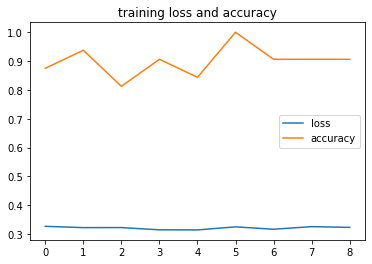

In [7]:
start_time = time.time()

epochs = 3
itr = 1
p_itr = 200
device='cuda:0'
vgg16.train()
total_loss = 0
loss_list = []#ve do thi
acc_list = []#ve do thi
time_take = time.time()
for epoch in range(epochs):
    for samples, labels in dataloaders[TRAIN]:
        samples = samples.to(device)
        labels  =  labels.to(device)
        optimizer.zero_grad()
        output = vgg16(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        
        if itr%p_itr == 0:#lap moi 200 samples 
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            time_take = time.time() - time_take
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}, Training complete in {:.0f}m {:.0f}s'.format(epoch+1, epochs, itr, total_loss/p_itr, acc,time_take//60,time_take%60))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
        itr += 1
        # del outputs, pred
end_time = time.time()
print('Time to train model in Pytorch: %f ms' % ((end_time - start_time) * 1000))

torch.cuda.empty_cache()
plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [0]:
# # filename_pth = 'vgg16_with_torch_catdogDS.pth'
# # torch.save(vgg16.state_dict(), filename_pth)

# # test_transform = transforms.Compose([
# #     transforms.Resize((128,128)),
# #     transforms.ToTensor()
# # ])


# # x: datasets.ImageFolder(
# #         os.path.join(dset_dir, x), 
# #         transform=data_transforms[x]
# #     )
# # dataloaders = {
# #     x: torch.utils.data.DataLoader(
# #         image_datasets[x], batch_size=32,
# #         shuffle=True, num_workers=4
# #     )
# #     for x in [TRAIN, VAL]
# # }
# test_dataset = datasets.ImageFolder(os.path.join('data_test','test1'),transform=data_transforms[TEST])
# # print(test_dataset)
# testloader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True,num_workers=4)
# print(testloader)


FileNotFoundError: ignored

In [0]:
imsize = 256
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
from PIL import Image
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open('../content/temp/test1/'+image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.to('cuda:0')  #assumes that you're using GPU

In [9]:
start_time = time.time()

lst = []
lst1=[]
ii =0
for img in os.listdir('../content/temp/test1/'):
  ii+=1
  if ii >=100:
    break
  lst.append((image_loader(img),img))

from keras.preprocessing import image
vgg16.eval()
plt.figure(figsize=(30,20))
i = 0
for item in lst:
  plt.subplot(10,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  t = vgg16(item[0])
  path='../content/temp/test1/'+str(item[1])
  img=image.load_img(path,target_size=(224,224))
  img= np.asarray(img)
  plt.imshow(img)
  img= np.expand_dims(img,axis=0)
  pred = torch.argmax(t, dim=1)
  if str(pred[0].item()) == '0':
      plt.xlabel('Pic '+ str(item[1]) + ': CAT')
  else:
      plt.xlabel('Pic '+ str(item[1]) + ': DOG')
  i+=1

end_time = time.time()
print('Time to train model in Tensorflow: %f ms' % ((end_time - start_time) * 1000))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# vgg16.eval()
# fn_list = []
# pred_list = []

# for x, fn in testloader:
#     # print(fn)
#     with torch.no_grad():
#         x = x.to('cuda:0')
#         output = vgg16(x)
#         pred = torch.argmax(output, dim=1)
        
#         fn_list += [n[:-4] for n in fn]
#         pred_list += [p.item() for p in pred]

# submission = pd.DataFrame({"id":fn_list, "label":pred_list})
# submission.to_csv('preds.csv', index=False)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7ee6c66898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7ee6c66898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    assert self._parent_pid == 

1


IndexError: ignored

In [0]:
# #danh gia model
# def eval_model(vgg, criterion):
#     since = time.time()
#     avg_loss = 0
#     avg_acc = 0
#     loss_test = 0
#     acc_test = 0
    
#     test_batches = len(dataloaders[TEST])
#     print("Evaluating model")
#     print('-' * 10)
    
#     for i, data in enumerate(dataloaders[TEST]):
#         if i % 100 == 0:
#             print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

#         vgg.train(False)
#         vgg.eval()
#         inputs, labels = data

#         if use_gpu:
#             inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
#         else:
#             inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

#         outputs = vgg(inputs)

#         _, preds = torch.max(outputs.data, 1)
#         loss = criterion(outputs, labels)

#         loss_test += loss.data[0]
#         acc_test += torch.sum(preds == labels.data)

#         del inputs, labels, outputs, preds
#         torch.cuda.empty_cache()
        
#     avg_loss = loss_test / dataset_sizes[TEST]
#     avg_acc = acc_test / dataset_sizes[TEST]
    
#     elapsed_time = time.time() - since
#     print()
#     print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
#     print("Avg loss (test): {:.4f}".format(avg_loss))
#     print("Avg acc (test): {:.4f}".format(avg_acc))
#     print('-' * 10)